# New architecture laboratory

**Author: @THEFFTKID**

Main notebook for experimentation.

In [1]:
cd ~/downloads/Pedro-Pineapple/forecasting

/home/aargaez/downloads/Pedro-Pineapple/forecasting


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import environments
import numpy as np
import torch as th
import evaluation
import utils

from dynamic_threshold import define_threshold
from stable_baselines3 import A2C, PPO
from dataclasses import dataclass
from typing import List
from json import dumps

2023-11-22 20:58:08.047915: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 20:58:08.173097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 20:58:11.171877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Model parameters.
@dataclass
class ModelParameters:
    time_steps: int
    window_size: int
    data_path: str
    lower_threshold: float
    upper_threshold: float
    proportion: float
    features: List[str]

In [4]:
# Experiment parameters.
parameters = ModelParameters(
    time_steps=500,
    window_size=10,
    data_path='~/downloads/Pedro-Pineapple/data/SPY_20122016.csv',
    lower_threshold=.5,
    upper_threshold=.5,
    proportion=0.8,
    features=[
        'open',
        'high',
        'low',
        'volume_roc',
        'n10_rolling_mean',
        'n10_weighted_rolling_mean',
        'momentum',
        'close',
        'nday_tendency_removal'
    ]
)

In [5]:
# Read data.
data = pd.read_csv(filepath_or_buffer=parameters.data_path)
# Cast columns.
data.columns = data.columns.str.lower()

data['labels'], data['perc_relative_diff'] = evaluation.create_labels(
    x=data['close'],
    labels=[0, 1, 2],
    perc_bounds=[
        parameters.lower_threshold,
        parameters.upper_threshold
    ]
)

# Split dataset into train and test.
df_train, df_test = evaluation.data_splitter(
    raw_data=data,
    proportion=parameters.proportion
)

info {'total_reward': 361.3701849999999} 



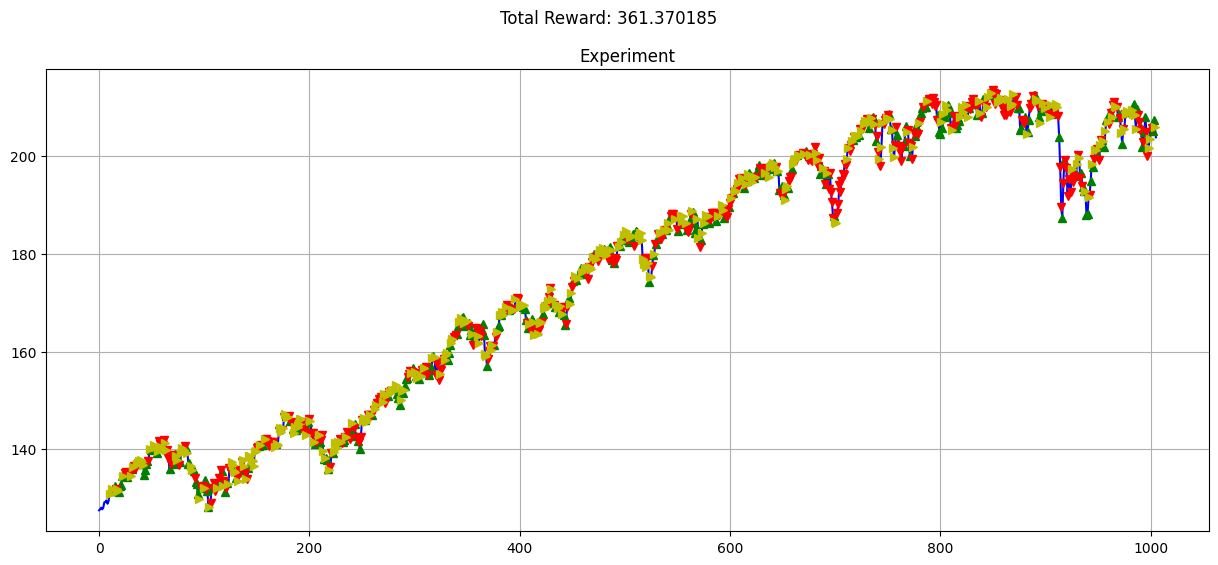

In [6]:
# Create the environment.
env = environments.Forecasting(
    df=df_train,
    window_size=parameters.window_size,
    series_features=parameters.features,
    lower_threshold=parameters.lower_threshold,
    upper_threshold=parameters.upper_threshold
)

# Random walk.
state = env.reset(seed=2008)

while True:
    # Sample action from space.
    action = env.action_space.sample()
    n_state, reward, done, truncated, info = env.step(
        action=action
    )

    if done or truncated:
        print('info', info, '\n')
        break

plt.figure(figsize=(15, 6))
plt.cla()
env.render_all(title='Experiment')
plt.show()

In [7]:
# Define new architecture.
policy_kwargs = dict(net_arch=[dict(pi=[128, 128, 128], vf=[128, 128, 128])])

In [8]:
# Train environment.
model = PPO(
    'MlpPolicy',
    env,
    verbose=1,
    policy_kwargs=policy_kwargs
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/aargaez/downloads/Pedro-Pineapple/venvpp/lib/python3.8/site-packages/stable_baselines3/common/policies.py:460: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [9]:
# Learn.
model.learn(total_timesteps=parameters.time_steps)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 995      |
|    ep_rew_mean     | 361      |
| time/              |          |
|    fps             | 402      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------


info {'total_reward': 105.08988899999994} 



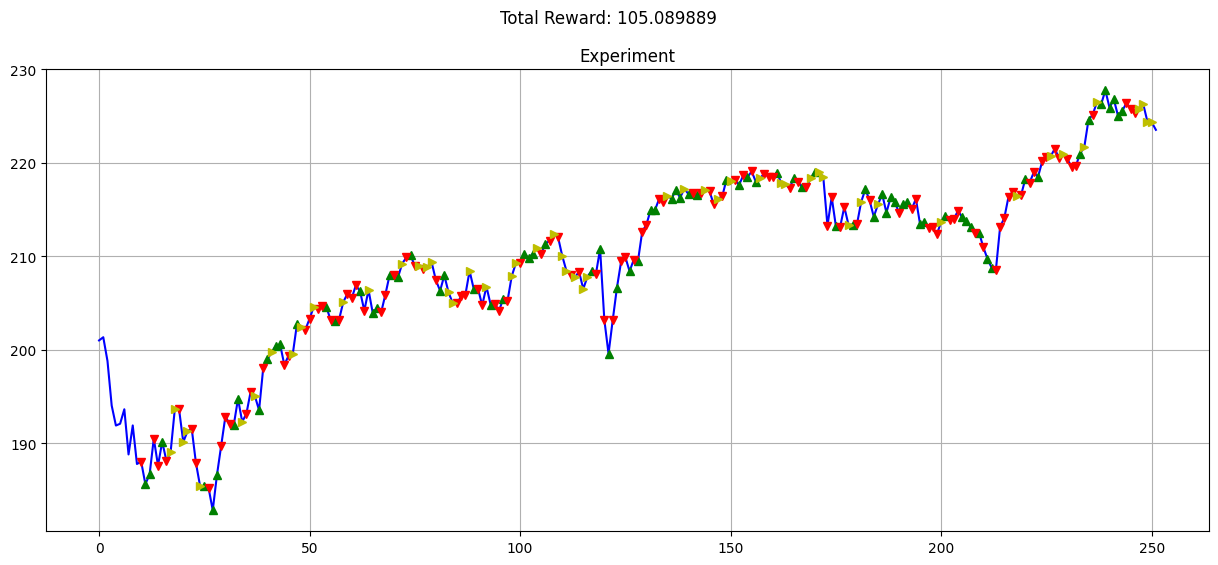

In [10]:
# Initialize a new environment with test-set.
env_test = environments.Forecasting(
    df=df_test,
    window_size=parameters.window_size,
    series_features=parameters.features,
    lower_threshold=parameters.lower_threshold,
    upper_threshold=parameters.upper_threshold
)

# Reset environment.
observation, info = env_test.reset(
    upper_threshold=env.up_threshold,
    lower_threshold=env.low_threshold
)

while True: 
    observation = observation[np.newaxis, ...]
    action, states = model.predict(observation)
    observation, rewards, done, truncated, info = env_test.step(action)
    if done or truncated:
        print('info', info, '\n')
        break

plt.figure(figsize=(15, 6))
plt.cla()
env_test.render_all(title='Experiment')
plt.show()

In [11]:
y_true = df_test['labels'].to_numpy()[parameters.window_size + 1:]
y_pred = np.concatenate(env_test.actions_history)

performance = evaluation.evaluation_metrics(
    y_true=y_true,
    y_pred=y_pred,
    target_names=['down', 'no', 'up']
)

print(dumps(performance, indent=4))

{
    "down": {
        "precision": 0.37383177570093457,
        "recall": 0.41237113402061853,
        "f1-score": 0.3921568627450981,
        "support": 97.0
    },
    "no": {
        "precision": 0.12962962962962962,
        "recall": 0.2413793103448276,
        "f1-score": 0.1686746987951807,
        "support": 29.0
    },
    "up": {
        "precision": 0.45,
        "recall": 0.3130434782608696,
        "f1-score": 0.36923076923076925,
        "support": 115.0
    },
    "accuracy": 0.34439834024896265,
    "macro avg": {
        "precision": 0.31782046844352135,
        "recall": 0.3222646408754386,
        "f1-score": 0.3100207769236827,
        "support": 241.0
    },
    "weighted avg": {
        "precision": 0.3807922883910785,
        "recall": 0.34439834024896265,
        "f1-score": 0.35432498096627896,
        "support": 241.0
    }
}
